## Inclusile classifier model performance metrics with tf.Keras using data in TFRecord format

This notebook loads a trained model for the dense neural network using the Inclusive Classifier.
This uses as input the list of particles + the High Level Features. Data is prepared from Parquet using Apache Spark, into TFRecord format and used with tf.Data and tf.io in tf.keras.
Training is done in a separate notebook and/or distributed code.

To run this notebook we used the following configuration:
* *Software stack*: TensorFlow 2.0.0-rc0
* *Platform*: CentOS 7, Python 3.6

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

tf.version.VERSION
# only needed for TensorFlow 1.x
# tf.enable_eager_execution()

'2.0.0-rc0'

# Load the trained model

In [2]:
model_path = "./mymodel.tf"

model = tf.keras.models.load_model(model_path)

## Load test data in TFRecord format, using tf.data and tf.io

In [3]:
# test dataset 
PATH = "/home/canali/Data/testUndersampled.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r-*", shuffle=False)
#files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r-0000*")

In [4]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [5]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [6]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
# tunable
test_batch_size = 10240

test=parsed_test_dataset.batch(test_batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test=test.repeat()

In [8]:
num_test_samples=856090 # there are 856090 samples in the test dataset

validation_steps=num_test_samples//test_batch_size  
validation_steps

83

## Confusion Matrix

In [9]:
%time model.evaluate(test, steps=validation_steps)

83/83 [==============================] - 42s 505ms/step - loss: 0.1128 - accuracy: 0.9596
CPU times: user 3min 11s, sys: 44.2 s, total: 3min 55s
Wall time: 42 s


[0.11281443306480546, 0.95959854]

In [10]:
%time y_pred = model.predict(test, steps=validation_steps)
num_entries=y_pred[:,0].size

CPU times: user 3min 7s, sys: 40.1 s, total: 3min 47s
Wall time: 39.5 s


In [11]:
%time y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

CPU times: user 5min 2s, sys: 47 s, total: 5min 49s
Wall time: 2min 34s


In [12]:
y_true = np.stack(y_test_all[:num_entries])

In [13]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9596


<IPython.core.display.Javascript object>


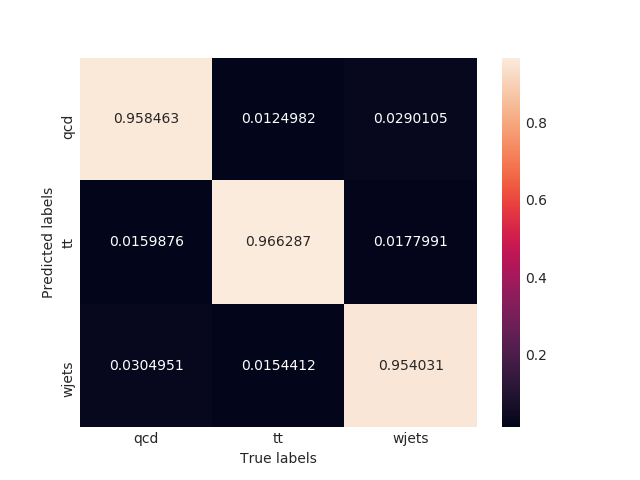

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Example test label and model prediction

In [15]:
y_true[:4]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [16]:
y_pred[:4]

array([[9.9958092e-01, 2.4495419e-04, 1.7413442e-04],
       [4.8228692e-05, 9.9961072e-01, 3.4099948e-04],
       [6.6918891e-04, 9.9788254e-01, 1.4482477e-03],
       [4.7982630e-05, 9.9947387e-01, 4.7808807e-04]], dtype=float32)

## ROC and AUC

In [17]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [18]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9956209434429777, 1: 0.9972418860089601, 2: 0.9952398930182931}

<IPython.core.display.Javascript object>


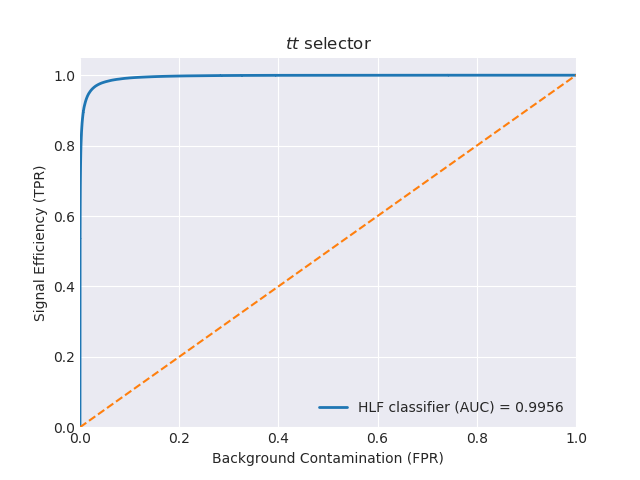

In [19]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()